### 1. 라이브러리 선언 및 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# ## 1. 데이터 불러오기

salesData = pd.read_csv("./dataset/pro_actual_sales.csv")
salesData.columns = salesData.columns.str.upper() 
salesData.head()

,REGIONSEG1,PRODUCTSEG1,PRODUCTSEG2,REGIONSEG2,REGIONSEG3,PRODUCTSEG3,YEARWEEK,YEAR,WEEK,QTY
0,A01,NaN,PG05,SALESID0001,SITEID0004,ITEM0445,201306,2013,6,5
1,A01,NaN,PG05,SALESID0001,SITEID0004,ITEM0445,201307,2013,7,8
2,A01,NaN,PG05,SALESID0001,SITEID0004,ITEM0445,201308,2013,8,7
3,A01,NaN,PG05,SALESID0001,SITEID0004,ITEM0445,201309,2013,9,1
4,A01,NaN,PG05,SALESID0001,SITEID0004,ITEM0445,201310,2013,10,1


### 2. 데이터 정제 (2년 이상 실적 자료 정제 및 53주차 제거된 풀데이터 셋)

In [5]:
# ##### 제품 별로 데이터 나누기

groupkey = ["REGIONSEG1","REGIONSEG2","REGIONSEG3","PRODUCTSEG2","PRODUCTSEG3"]
groupData = salesData.groupby(groupkey)['YEARWEEK','YEAR','WEEK','QTY']
groupData

In [6]:
groupsData = salesData.groupby(groupkey)["YEARWEEK"].agg(["count"]).reset_index()

In [7]:
groupsData = groupsData.rename(columns={"count":"KNOB"})

In [8]:
# 모든 데이터를 key(groupKey)와 data로 나누고 매칭시켜 딕셔너리로 변환할건데,  
# seq_length를 고려해서 52주차 이상의 실적이 있는 데이터만 선별하여 담는다.

In [9]:
joinData = pd.merge(left=salesData, right=groupsData,on=groupkey)

maxKnob = 104

cleansedData = joinData[joinData.KNOB >= maxKnob]

len(cleansedData.PRODUCTSEG3.drop_duplicates())

96

In [10]:
# # normalizing

# newqty=[]

# for i in range(0,len(each_data)):
#     maxval = each_data[i]["QTY"].max()
#     each_data[i]["QTY"].values.astype('float')
#     tmpqty= each_data[i]["QTY"].values #/maxval
#     newqty.append(tmpqty)
    
#     each_data[i]["NEW_QTY"]=""
#     each_data[i]["NEW_QTY"]=tmpqty

In [11]:
eachItem = cleansedData[(cleansedData.PRODUCTSEG3 =="ITEM0110") &
                        (cleansedData.REGIONSEG3 == "SITEID0004")]

In [12]:
eachItem2 = eachItem.reset_index(drop=True)

In [13]:
len(eachItem)

154

In [14]:
eachItem2.describe()

,PRODUCTSEG1,YEARWEEK,YEAR,WEEK,QTY,KNOB
count,0.0,154.000000,154.000000,154.000000,154.000000,154.0
mean,NaN,201481.818182,2014.551948,26.623377,148.123377,154.0
std,NaN,88.519593,0.943102,15.300510,179.190202,0.0
min,NaN,201331.000000,2013.000000,1.000000,8.000000,154.0
25%,NaN,201417.250000,2014.000000,13.250000,56.000000,154.0
50%,NaN,201503.500000,2015.000000,26.000000,76.500000,154.0
75%,NaN,201541.750000,2015.000000,40.000000,139.250000,154.0
max,NaN,201627.000000,2016.000000,53.000000,1147.000000,154.0


### 데이터 분리

In [15]:
trainData = eachItem2[ (eachItem2.YEARWEEK >= 201401) &
                       (eachItem2.YEARWEEK < 201553) ].reset_index(drop=True)

In [16]:
testData = eachItem2[ (eachItem2.YEARWEEK > 201600)].reset_index(drop=True)

### 모델 생성

In [17]:
import warnings

warnings.filterwarnings(action="ignore")
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing , SimpleExpSmoothing 

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
trainData.head()

,REGIONSEG1,PRODUCTSEG1,PRODUCTSEG2,REGIONSEG2,REGIONSEG3,PRODUCTSEG3,YEARWEEK,YEAR,WEEK,QTY,KNOB
0,A01,NaN,PG01,SALESID0001,SITEID0004,ITEM0110,201401,2014,1,35,154
1,A01,NaN,PG01,SALESID0001,SITEID0004,ITEM0110,201402,2014,2,46,154
2,A01,NaN,PG01,SALESID0001,SITEID0004,ITEM0110,201403,2014,3,65,154
3,A01,NaN,PG01,SALESID0001,SITEID0004,ITEM0110,201404,2014,4,59,154
4,A01,NaN,PG01,SALESID0001,SITEID0004,ITEM0110,201405,2014,5,40,154


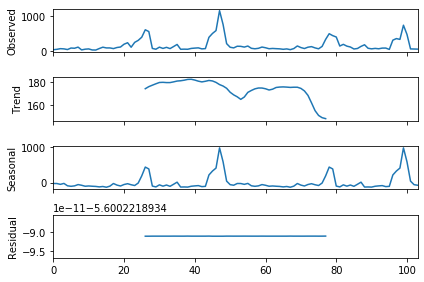

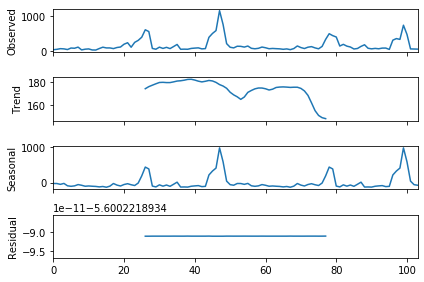

In [19]:
trainData_a = trainData.set_index("YEARWEEK")

a = sm.tsa.seasonal_decompose(trainData.QTY,model= "add", freq=52)
a.plot()

In [24]:
M = 'multiplicative'
A = 'additive'
model_ETS = ExponentialSmoothing(trainData.QTY,  trend=M, seasonal=M,  seasonal_periods=52 )

In [25]:
# p,q value define (1,2)
model_ARMA = sm.tsa.ARMA(trainData.QTY, (1,2))

In [26]:
from pmdarima import auto_arima   

auto_arima(trainData.QTY).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  104
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -645.188
Date:                Sun, 10 Nov 2019   AIC                           1298.375
Time:                        21:19:12   BIC                           1308.953
Sample:                             0   HQIC                          1302.660
                                - 104                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     89.0420     39.110      2.277      0.023      12.387     165.697
ar.L1          0.4361      0.102      4.291      0.000       0.237       0.635
ma.L1          0.6063      0.124      4.887      0.000       0.363       0.850
sigma2      1.417e+04   1244.307     11.385      0.000    1.17e+04    1.66e+04
===================================================================================
Ljung-Box (Q):                       27.20   Jarque-Bera (JB):               505.74
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                             2.25
Prob(H) (two-sided):                  0.10   Kurtosis:                        12.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
from pmdarima import auto_arima   

auto_arima(trainData.QTY).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  104
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -645.188
Date:                Sun, 10 Nov 2019   AIC                           1298.375
Time:                        21:19:31   BIC                           1308.953
Sample:                             0   HQIC                          1302.660
                                - 104                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     89.0420     39.110      2.277      0.023      12.387     165.697
ar.L1          0.4361      0.102      4.291      0.000       0.237       0.635
ma.L1          0.6063      0.124      4.887      0.000       0.363       0.850
sigma2      1.417e+04   1244.307     11.385      0.000    1.17e+04    1.66e+04
===================================================================================
Ljung-Box (Q):                       27.20   Jarque-Bera (JB):               505.74
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                             2.25
Prob(H) (two-sided):                  0.10   Kurtosis:                        12.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_ARIMA = SARIMAX(trainData['QTY'], order = (1,0,1))

### 모델 훈련

### 1. ets 모델

In [29]:
result_ETS = model_ETS.fit()
print(result_ETS.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  104
Model:             ExponentialSmoothing   SSE                         293067.412
Optimized:                         True   AIC                            938.152
Trend:                   Multiplicative   BIC                           1086.238
Seasonal:                Multiplicative   AICC                          1090.241
Seasonal Periods:                    52   Date:                 Sun, 10 Nov 2019
Box-Cox:                          False   Time:                         21:19:34
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5789474                alpha                 True
smoothing_slope          

### 2. auto arima 모델

In [30]:
result_ARIMA = model_ARIMA.fit()
result_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    QTY   No. Observations:                  104
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -651.728
Date:                Sun, 10 Nov 2019   AIC                           1309.456
Time:                        21:19:35   BIC                           1317.389
Sample:                             0   HQIC                          1312.670
                                - 104                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6831      0.057     12.020      0.000       0.572       0.794
ma.L1          0.4972      0.093      5.348      0.000       0.315       0.679
sigma2      1.601e+04   1081.071     14.809      0.000    1.39e+04    1.81e+04
===================================================================================
Ljung-Box (Q):                       30.47   Jarque-Bera (JB):               280.00
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.84   Skew:                             1.24
Prob(H) (two-sided):                  0.08   Kurtosis:                        10.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3. auto arma 모델

In [31]:
### AR (Autoregression), MA(Moving Average)

In [32]:
# p,q value define (1,2)
model_ARMA = sm.tsa.ARMA(trainData.QTY, (1,2))

In [33]:
result_ARMA = model_ARMA.fit()
print(result_ARMA.summary())

                              ARMA Model Results                              
Dep. Variable:                    QTY   No. Observations:                  104
Model:                     ARMA(1, 2)   Log Likelihood                -644.690
Method:                       css-mle   S.D. of innovations            118.448
Date:                Sun, 10 Nov 2019   AIC                           1299.381
Time:                        21:19:37   BIC                           1312.603
Sample:                             0   HQIC                          1304.737
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        157.0933     35.966      4.368      0.000      86.601     227.585
ar.L1.QTY      0.5920      0.158      3.747      0.000       0.282       0.902
ma.L1.QTY      0.4335      0.178      2.431      0.0

### 예측

In [20]:
trainData.describe()

,PRODUCTSEG1,YEARWEEK,YEAR,WEEK,QTY,KNOB
count,0.0,104.000000,104.000000,104.000000,104.000000,104.0
mean,NaN,201476.500000,2014.500000,26.500000,160.807692,154.0
std,NaN,52.456732,0.502421,15.081011,183.768167,0.0
min,NaN,201401.000000,2014.000000,1.000000,26.000000,154.0
25%,NaN,201426.750000,2014.000000,13.750000,62.000000,154.0
50%,NaN,201476.500000,2014.500000,26.500000,86.500000,154.0
75%,NaN,201526.250000,2015.000000,39.250000,140.500000,154.0
max,NaN,201552.000000,2015.000000,52.000000,1147.000000,154.0


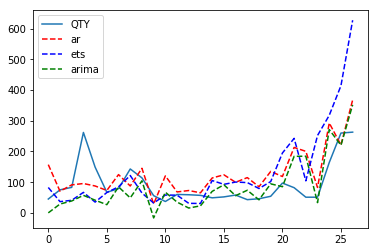

In [34]:
predictValue_arma = result_ARMA.predict(0,26).reset_index(drop=True)
predictValue_arima = result_ARIMA.predict(0,26).reset_index(drop=True)
predictValue_ets = result_ETS.predict(0,26).reset_index(drop=True)

testData["PREDICT_ARMA"] = predictValue_arma
testData["PREDICT_ETS"] = predictValue_ets
testData["PREDICT_ARIMA"] = predictValue_arima

plt.plot(testData.index, testData.QTY)
plt.plot(testData.index, testData.PREDICT_ARMA, "r--", label="ar")
plt.plot(testData.index, testData.PREDICT_ETS, "b--", label="ets")
plt.plot(testData.index, testData.PREDICT_ARIMA, "g--", label="arima")
plt.legend()